In [34]:
import networkx as nx
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import os
import json
from scipy import stats
sns.set()
from multiprocessing import Pool

# Metric analysis of DAOs
This file will take the metrics proposed in [this mirror article](https://mirror.xyz/itamarg.eth/Cxs_pTvMQ3-Udj1MYDZW46OZxGnHET1cHQX_tTozckw). To summarize, it will have 9 sections, one for each metric:
1. Member conversion funnel
2. Small world score
3. Top-5 connectors & outliers
4. Proposal approval rate
5. Voting participation rate
6. Rolling voting participation rate
7. Top 10 outflows
8. Plan vs. actual spend
9. Community token Gini index

## Data and scope
This analysis will be run accross all DAOs that are available on DAOHaus, and on Snapshot.

# Member conversion funnel
This metric is not necessarily the easiest to get accross all DAOs as they might all have a different governance model that they abide with. I will focus on DAOHaus data for this and take the following assumptions:
- A person enters the DAO (first level) when they become a member
- A level in the DAO is reflected by the number of proposals made by the member afterwards
- A level in the DAO is reflected by the number of votes made by the member afterwards

Therefore the conversion funnel will be an abstraction of the participation of the member in the DAO. For snapshot data, this is similar to the voter retention issue I worked  on in the past.

In [72]:
sns.set_context("talk")

In [73]:
daos = pd.read_csv("../../DiamondDAO_SQL_DB/daohaus.dao.csv")
members = pd.read_csv("../../DiamondDAO_SQL_DB/daohaus.member.csv")
proposals = pd.read_csv("../../DiamondDAO_SQL_DB/daohaus.proposal.csv")
votes = pd.read_csv("../../DiamondDAO_SQL_DB/daohaus.proposal_votes.csv")

In [74]:
tmp = votes.merge(proposals, left_on="proposal_id", right_on="id")
tmp_votes = tmp.groupby(["dao_id", "member_id"], as_index=False).count()
tmp_votes = tmp_votes.merge(members[["id", "address"]], left_on="member_id", right_on="id")[["dao_id", "id_x", "address"]]
tmp_votes = tmp_votes.rename(columns={"id_x":"votes_count"})

In [75]:
tmp_proposals = proposals[proposals['newMember'] != "t"].groupby(['dao_id',"proposer"], as_index=False).count()[['dao_id', "proposer", "id"]]
tmp_proposals = tmp_proposals.rename(columns={"id":"proposals_count", "proposer":"address"})

In [76]:
action_counts = tmp_proposals.merge(tmp_votes, left_on=["dao_id", "address"], right_on=["dao_id", "address"],how="outer")
action_counts["proposals_count"] = action_counts["proposals_count"].fillna(0)
action_counts["votes_count"] = action_counts["votes_count"].fillna(0)
action_counts["action_count"] = action_counts["proposals_count"] + action_counts["votes_count"]

In [77]:
counts = []
for dao_id in daos['id'].unique():
    data = action_counts[action_counts['dao_id'] == dao_id]
    members_count = len(members[members['dao_id'] == dao_id])
    tmp = {
        "dao_id": dao_id,
        "level0": 1.0,
        "level1":0,
        "level2":0,
        "level3":0,
        "level4":0,
        "level5":0,
        "level6":0,
        "level7":0,
        "level8":0,
        "level9":0,
        "level10":0,
    }
    if len(data)>0:
        for i in range(1, 11):
            tmp["level{}".format(i)] = len(data[data['action_count'] >= i])/members_count
    counts.append(tmp)
levels_daohaus = pd.DataFrame.from_dict(counts)

<ipython-input-78-95841920ba9a>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.axes[0].set_xticklabels(range(11))


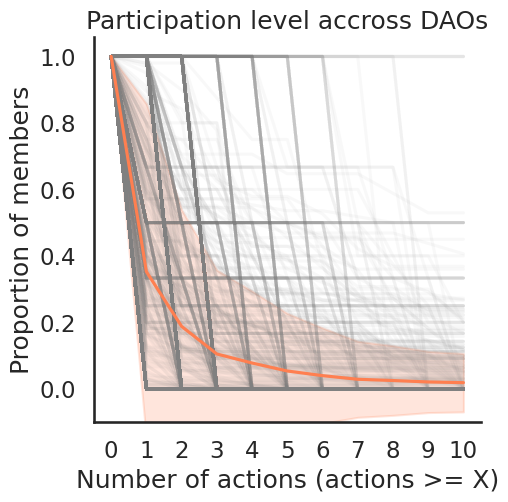

In [78]:
fig = plt.figure(figsize=(5,5))
sns.set_style("white")
data = levels_daohaus.melt(id_vars="dao_id")
for daodata in levels_daohaus.values:
    if not (daodata[1:] > 1).any():
        plt.plot(range(11), daodata[1:], alpha=0.05, color="grey")
sns.lineplot(data=data, x="variable", y="value", ci="sd", color="coral", markers=True)
sns.despine()
plt.ylim(-0.1)
plt.xlabel("Number of actions (actions >= X)")
plt.ylabel("Proportion of members")
plt.title("Participation level accross DAOs")
fig.axes[0].set_xticklabels(range(11))
plt.savefig("ParticipationLevelDAOHaus.svg")
plt.show()


### Snapshot DAOs

In [79]:
pathToData = "../../shoot-your-snapshot/SnapshotScrapper/results"

In [80]:
data = []

In [81]:
with open(os.path.join(pathToData, "spaces.json")) as f:
    spaces = json.load(f)
    
for space in tqdm(spaces):
    spacePath = os.path.join(pathToData, "spaces", space["id"])
    if os.path.isdir(spacePath):
        proposals = os.listdir(spacePath)
        if len(proposals) > 1:
            for proposalPath in proposals:
                with open(os.path.join(spacePath, proposalPath)) as f:
                    proposal = json.load(f)
                data.append({
                    "space_id": space['id'],
                    "proposal_id": proposal["id"],
                    "action_type": "proposal",
                    "address": proposal["author"]
                })
                for vote in proposal["votes_data"]:
                    data.append({
                        "space_id": space['id'],
                        "proposal_id": proposal["id"],
                        "action_type": "vote",
                        "address": vote["voter"]
                    })
    else:
        print("missing folder: {}".format(space["id"]))

  0%|          | 0/3490 [00:00<?, ?it/s]

In [82]:
snapshot_data = pd.DataFrame.from_dict(data)

In [83]:
tmp = snapshot_data.groupby(["space_id", "action_type"], as_index=False).count()
snapshot_data = snapshot_data[snapshot_data["space_id"].isin(tmp[tmp["action_type"] == "vote"]["space_id"].unique())]

In [84]:
tmp = snapshot_data.groupby(["space_id", "address"], as_index=False).count().groupby(["space_id"], as_index=False).count()
snapshot_data = snapshot_data[snapshot_data["space_id"].isin(tmp[tmp["address"]>1]["space_id"].unique())]

In [85]:
action_counts = snapshot_data.groupby(["space_id", "address"], as_index=False).count()

In [86]:
data = []
for space_id in tqdm(snapshot_data['space_id'].unique()):
    tmpdata = action_counts[action_counts["space_id"] == space_id]
    member_count = len(tmpdata)
    tmp = {
        "space_id": space_id, 
    }
    for i in range(11):
        tmp["level{}".format(i)] = len(tmpdata[tmpdata["action_type"]>i])/member_count
    data.append(tmp)
levels_snapshot = pd.DataFrame.from_dict(data)

  0%|          | 0/1240 [00:00<?, ?it/s]

<ipython-input-87-9bfe73de6908>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.axes[0].set_xticklabels(range(11))


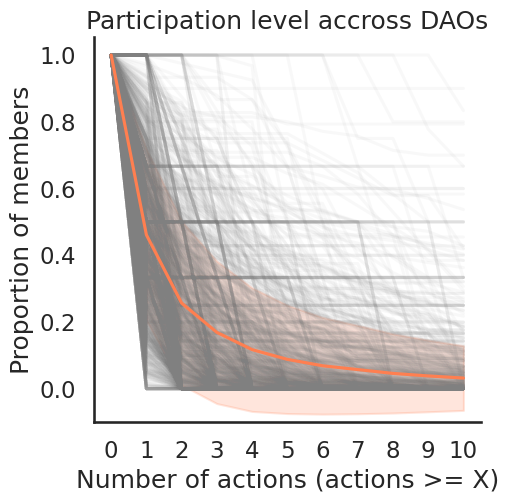

In [87]:
fig = plt.figure(figsize=(5,5))
sns.set_style("white")
data = levels_snapshot.melt(id_vars="space_id")
for daodata in levels_snapshot.values:
    if not (daodata[1:] > 1).any():
        plt.plot(range(11), daodata[1:], alpha=0.05, color="grey")
sns.lineplot(data=data, x="variable", y="value", ci="sd", color="coral", markers=True)
sns.despine()
plt.ylim(-0.1)
plt.xlabel("Number of actions (actions >= X)")
plt.ylabel("Proportion of members")
plt.title("Participation level accross DAOs")
fig.axes[0].set_xticklabels(range(11))
plt.savefig("ParticipationLevelSnapshot.svg")
plt.show()

## Comparing Snapshot to DAOhaus

In [88]:
levels_snapshot = levels_snapshot.rename(columns={"space_id": "dao_id"})
levels_snapshot["DAO platform"] = "Snapshot"
levels_daohaus["DAO platform"] = "DAOHaus"
levels = levels_snapshot.append(levels_daohaus)

<ipython-input-89-1aa598080c17>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.axes[0].set_xticklabels(range(11))


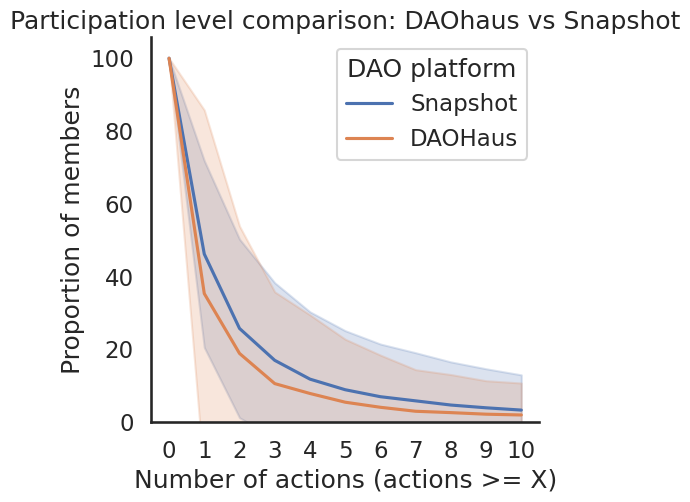

In [89]:
fig = plt.figure(figsize=(5,5))
sns.set_style("white")
data = levels.melt(id_vars=["dao_id", "DAO platform"])
data["value"] = data["value"] * 100
sns.lineplot(data=data, x="variable", y="value", ci="sd", hue="DAO platform", markers=True)
sns.despine()
plt.ylim(-0.1)
plt.xlabel("Number of actions (actions >= X)")
plt.ylabel("Proportion of members")
plt.title("Participation level comparison: DAOhaus vs Snapshot")
fig.axes[0].set_xticklabels(range(11))
plt.savefig("ParticipationLevelComparison.svg")
plt.show()

# Small World networks & Top-5 connectors & outliers
Here we will need to generate the members networks, we will compute the co-voter network for this, which assumes that two members are connected if they both voted on the same proposal. 

I use the definition of a Small World Score defined here: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002051. But with the change that we are basing it on the random model of Watts-Strogatz. Therefore we can use the [Omega](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.smallworld.omega.html) and [Sigma](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.smallworld.sigma.html) computation of NetworkX, but those are very slow. Sigma is equivalent to the S of the Plos One article.

For the centrality I simply use the networkX implementation of both computations

In [90]:
daos = pd.read_csv("../../DiamondDAO_SQL_DB/daohaus.dao.csv")
members = pd.read_csv("../../DiamondDAO_SQL_DB/daohaus.member.csv")
proposals = pd.read_csv("../../DiamondDAO_SQL_DB/daohaus.proposal.csv")
votes = pd.read_csv("../../DiamondDAO_SQL_DB/daohaus.proposal_votes.csv")
daohaus_data = votes.merge(proposals, left_on="proposal_id", right_on="id").merge(members, left_on="member_id", right_on="id")[["dao_id_x", "proposal_id_x", "address"]]
daohaus_data = daohaus_data.rename(columns={"dao_id_x":"dao_id", "proposal_id_x":"proposal_id"})
daohaus_data["datasource"] = "DAOHaus"

In [20]:
pathToData = "../../shoot-your-snapshot/SnapshotScrapper/results"
snapshot_data = []
with open(os.path.join(pathToData, "spaces.json")) as f:
    spaces = json.load(f)
    
for space in tqdm(spaces):
    spacePath = os.path.join(pathToData, "spaces", space["id"])
    if os.path.isdir(spacePath):
        proposals = os.listdir(spacePath)
        if len(proposals) > 1:
            for proposalPath in proposals:
                with open(os.path.join(spacePath, proposalPath)) as f:
                    proposal = json.load(f)
                for vote in proposal["votes_data"]:
                    snapshot_data.append({
                        "dao_id": space['id'],
                        "proposal_id": proposal["id"],
                        "address": vote["voter"]
                    })
    else:
        print("missing folder: {}".format(space["id"]))
snapshot_data = pd.DataFrame.from_dict(snapshot_data)
snapshot_data["datasource"] = "Snapshot"

  0%|          | 0/3490 [00:00<?, ?it/s]

In [21]:
data = snapshot_data.append(daohaus_data)

In [22]:
def Zscore(x, mu, sigma):
    if sigma == 0:
        sigma = 0.00001
    return (x-mu)/sigma

In [23]:
def make_network(row, G=None):
    G.add_node(row["address"], node_type="Member")
    G.add_node(row["proposal_id"], node_type="Proposal")
    G.add_edge(row["address"], row["proposal_id"])

In [24]:
data

,dao_id,proposal_id,address,datasource
0,32222.eth,0x76f298b3b130b18783a8d5957915ba2373c93019dd8d...,0xD3E8d1d5034D54dA12da0Db3b2c26679D69A93C5,Snapshot
1,32222.eth,0xee8dfb3f14a0798a10476bd1d52be26bdc4bcf99f042...,0xD3E8d1d5034D54dA12da0Db3b2c26679D69A93C5,Snapshot
2,32222.eth,0x04d11744024c8aa1fad65e148cb32cf24957252dd7c6...,0xD3E8d1d5034D54dA12da0Db3b2c26679D69A93C5,Snapshot
3,testsnapshot.eth,0x855fdb27480b481d60ea2d8a14c4105f0467962f2fef...,0xC0855f464261832aa43f1d9d9E1cC2aCeEF7c54b,Snapshot
4,testsnapshot.eth,0x855fdb27480b481d60ea2d8a14c4105f0467962f2fef...,0x8a93e113B62E009A4e3a04Dde9CDE3A440b7bf78,Snapshot
...,...,...,...,...
12034,1578,7188,0xf05c004c9a3d801644d6bbb18de836ce998de27f,DAOHaus
12035,1583,7220,0x17fd68f4f3035a1b51e6e662238784001f76a8f9,DAOHaus
12036,1583,7228,0x17fd68f4f3035a1b51e6e662238784001f76a8f9,DAOHaus
12037,1583,7234,0x17fd68f4f3035a1b51e6e662238784001f76a8f9,DAOHaus


In [24]:
def compute_smallworld_params(dao_id):
    # Based on this paper https://arxiv.org/pdf/2103.08035.pdf
    tmpdata = data[data['dao_id'] == dao_id]
    G = nx.Graph()
    tmpdata.apply(make_network, G=G, axis=1)
    members = [node for node in G.nodes() if G.nodes[node]["node_type"] == "Member"]
    voter_network = nx.algorithms.bipartite.projection.weighted_projected_graph(G, members)
    for edge in voter_network.edges:
        if voter_network.edges[edge]["weight"] == 1:
            voter_network.remove_edge(edge[0],edge[1])
    lcc = [cc for cc in nx.connected_components(voter_network)][0]
    lcc = voter_network.subgraph(lcc)

    L = nx.average_shortest_path_length(lcc)
    C = nx.average_clustering(lcc)

    n = len(lcc)
    if n < 5: # Less than 5 is not testable
        return {}
    if n > 100: # I put this here, because literally I can't compute much larger networks than this without figuring out some really neat crafty fast compute stuff
        return {}
    k = np.mean([d[1] for d in lcc.degree])
    beta = 0.5
    p = nx.density(lcc)
    Crs = []
    Lrs = []
    for i in range(10):
        rndG = nx.random_graphs.newman_watts_strogatz_graph(n, int(k), p)
        Cr = nx.average_clustering(rndG)
        Lr = nx.average_shortest_path_length(rndG)
        Crs.append(Cr)
        Lrs.append(Lr)
    Crs_mu = np.mean(Crs)
    Crs_std = np.std(Crs)
    Lrs_mu = np.mean(Lrs)
    Lrs_std = np.std(Lrs)
    l = L/Lrs_mu
    g = C/Crs_mu
    Cz = Zscore(C, Crs_mu, Crs_std)
    Lz = Zscore(L, Lrs_mu, Lrs_std)
    closeness = nx.closeness_centrality(voter_network)
    closeness = np.mean([closeness[node] for node in closeness])
    betweenness = nx.betweenness_centrality(voter_network)
    betweenness = np.mean([betweenness[node] for node in betweenness])
    tmp = {
        "dao_id": dao_id,
        "L": L,
        "C": C,
        "L_zscore": Lz,
        "C_zscore": Cz,
        "lambda": l,
        "gamma": g,
        "Cr_mu": Crs_mu,
        "Cr_std": Crs_std,
        "Lr_mu": Lrs_mu,
        "Lr_std": Lrs_std,
        "closeness":closeness,
        "betweenness":betweenness
    }
    f = open("./tmp/{}.json".format(dao_id), 'w')
    f.write(json.dumps(tmp))
    f.close()
    return tmp

In [25]:
if not os.path.isdir("./tmp"):
    os.mkdir("./tmp")

In [ ]:
done = [f.replace(".json", "") for f in os.listdir("./tmp")]
todo = [dao for dao in data["dao_id"].unique() if dao not in done]
print(len(todo))
with Pool(8) as p:
    results = list(tqdm(p.imap(compute_smallworld_params, todo), total=len(todo)))
results = [r for r in results if len(r.keys())>0]
results = pd.DataFrame.from_dict(results)
results.to_csv("./network_metrics.csv")

1389


  0%|          | 0/1389 [00:00<?, ?it/s]

In [ ]:
def make_network(row, G=None):
    G.add_node(row["address"], node_type="Member")
    G.add_node(row["proposal_id"], node_type="Proposal")
    G.add_edge(row["address"], row["proposal_id"])
    
centrality_results = []
smallworld_results = []
for dao_id in tqdm(data["dao_id"].unique()):
    tmpdata = data[data['dao_id'] == dao_id]
    source = tmpdata["datasource"].values[0]
    G = nx.Graph()
    tmpdata.apply(make_network, G=G, axis=1)
    members = [node for node in G.nodes() if G.nodes[node]["node_type"] == "Member"]
    voter_network = nx.algorithms.bipartite.projection.projected_graph(G, members)
    lcc = [cc for cc in nx.connected_components(voter_network)][0]
    if len(lcc) > 100:
        break
#         omega = nx.algorithms.smallworld.omega(nx.subgraph(voter_network, lcc), niter=1)
#         sigma = nx.algorithms.smallworld.omega(nx.subgraph(voter_network, lcc), niter=1)
#         smallworld_results.append({
#             "dao_id": dao_id,
#             "datasource": source,
#             "size": len(voter_network.nodes()),
#             "lcc": len(lcc),
#             "omega": omega,
#             "sigma": sigma
#         })
#         betweenness = nx.betweenness_centrality(voter_network)
#         closeness = nx.closeness_centrality(voter_network)
#         for node in betwe                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      enness:
#             centrality_results.append({
#                 "dao_id": dao_id,
#                 "datasource": source,
#                 "member": node,
#                 "betweenness": betweenness[node],
#                 "closeness": closeness[node]
#             })
        
        
# smallworld_results = pd.DataFrame.from_dict(smallworld_results)
# smallworld_results.to_csv("voters_network_small_world_parameters.csv")
# centrality_results = pd.DataFrame.from_dict(centrality_results)
# centrality_results.to_csv("voters_network_centrality.csv")

In [35]:
closeness

0.603106343824079

<!-- # Proposal approval rate -->

Let's compute the proposal approval rate for all DAOs. As mentionned in the mirror article, having a 100% approval doesn't reflect perfect health. In contrast, the approval rate should be in a 65-90% approval rate. Another intersting aspect is to observe the dynamic of the approval rate. But because DAO's have existed for a different amount of time, we will rescale it to pseudo-time. The definition for the pseudo-time here will be the number of proposals at step i, divided by the total number at the end. 

Because Snapshot is used for much more than governance, we can't really use it easily for this analysis. For example "What will the price of MANA be?" is a proposal, which is not governance related, nor has a passed or not passed state. 

In [92]:
proposals = pd.read_csv("../../DiamondDAO_SQL_DB/daohaus.proposal.csv")

In [93]:
total_count = proposals.groupby("dao_id", as_index=False).count()[["dao_id", "didPass"]]
passed_count = proposals[proposals["didPass"] == "t"].groupby("dao_id", as_index=False).count()[["dao_id", "didPass"]]

In [94]:
daohaus_data = total_count.merge(passed_count, left_on="dao_id", right_on="dao_id").rename(columns={"didPass_x":"total", "didPass_y":"passed"})

In [95]:
daohaus_data["approval rate"] = daohaus_data["passed"]/daohaus_data["total"]

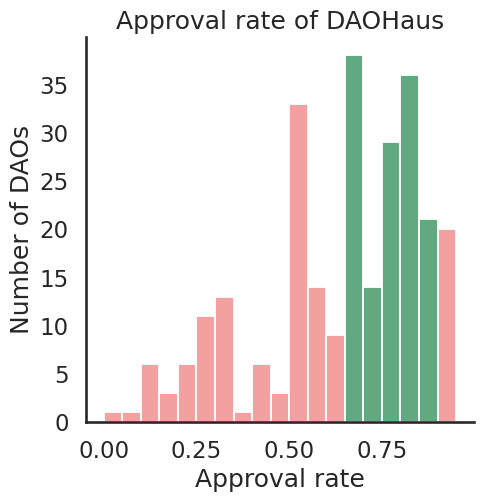

In [110]:
bad = daohaus_data[(daohaus_data["approval rate"] < 0.65) | (daohaus_data["approval rate"] >= 0.90)]["approval rate"]
good = daohaus_data[(daohaus_data["approval rate"] >= 0.65) & (daohaus_data["approval rate"] < 0.90)]["approval rate"]

plt.figure(figsize=(5,5))
sns.histplot(bad, bins=np.arange(0,1, 0.05), color="lightcoral")
sns.histplot(good, bins=np.arange(0,1, 0.05), color="seagreen")
sns.despine()
plt.xlabel("Approval rate")
plt.ylabel("Number of DAOs")
plt.title("Approval rate of DAOHaus")
plt.savefig("DistApprovalRate.svg")
plt.show()

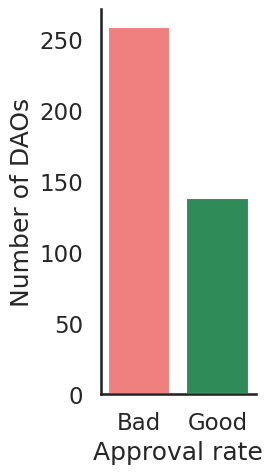

In [109]:
fig = plt.figure(figsize=(2,5))
bad = daohaus_data[(daohaus_data["approval rate"] < 0.65) | (daohaus_data["approval rate"] >= 0.90)]["approval rate"]
good = daohaus_data[(daohaus_data["approval rate"] >= 0.65) & (daohaus_data["approval rate"] < 0.90)]["approval rate"]
plt.bar([0, 1], [len(bad), len(good)], color=["lightcoral", "seagreen"])
sns.despine()
plt.xticks([0, 1], ["Bad", "Good"])
plt.xlabel("Approval rate")
plt.ylabel("Number of DAOs")
plt.savefig("DAOgoodbad.svg")
plt.show()

In [98]:
sorted(tmpdata["proposal_id"].unique())

[1]

In [99]:
results = []
for dao_id in proposals["dao_id"].unique():
    tmpdata = proposals[proposals["dao_id"] == dao_id]
    if len(tmpdata["proposal_id"].unique()) > 3:
        max_time = len(tmpdata["proposal_id"].unique())
        time = 0
        for proposal_id in sorted(tmpdata["proposal_id"].unique()):
            total = len(tmpdata[tmpdata["proposal_id"] <= proposal_id])
            passed = len(tmpdata[(tmpdata["proposal_id"] <= proposal_id) & (tmpdata["didPass"] == "t")])
            results.append({
                "dao_id": dao_id, 
                "pseudotime": time/max_time,
                "total": total,
                "passed": passed,
                "approvalRate": passed/total
            })
            time +=1 

In [100]:
results = pd.DataFrame.from_dict(results)

In [101]:
bins = np.arange(0,1.2,0.1)
binned = []

for point in results[["pseudotime", "approvalRate", "dao_id"]].values:
    for i in range(len(bins)):
        if point[0] < bins[i]:
            binned.append([point[2], bins[i-1], point[1]])
approval_rate_daohaus = pd.DataFrame(binned, columns=["dao_id", "pseudotime", "approvalRate"])

In [102]:
bad_daos = daohaus_data[(daohaus_data["approval rate"] < 0.65) | (daohaus_data["approval rate"] >= 0.90)]["dao_id"]
good_daos = daohaus_data[(daohaus_data["approval rate"] >= 0.65) & (daohaus_data["approval rate"] < 0.90)]["dao_id"]

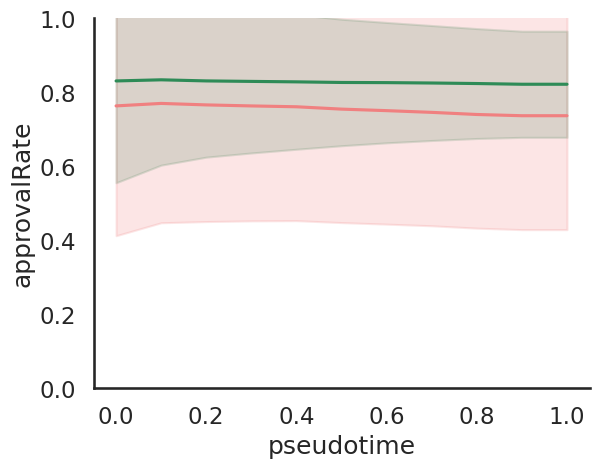

In [103]:
sns.set_style("white")
sns.lineplot(data=approval_rate_daohaus[approval_rate_daohaus["dao_id"].isin(good_daos)], x="pseudotime", y="approvalRate", ci="sd", color="seagreen")
sns.lineplot(data=approval_rate_daohaus[approval_rate_daohaus["dao_id"].isin(bad_daos)], x="pseudotime", y="approvalRate", ci="sd", color="lightcoral")
plt.ylim(0, 1)
sns.despine()
plt.show()

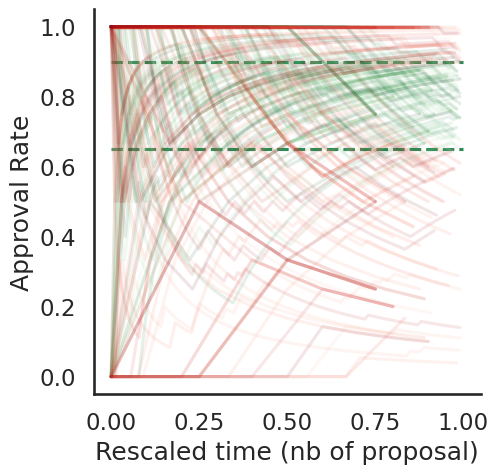

In [111]:
plt.figure(figsize=(5,5))
plt.hlines([0.9, 0.65], linestyles="dashed", xmin=0, xmax=1.0, color="seagreen")
sns.lineplot(data=results[results['dao_id'].isin(good_daos)], x="pseudotime", y="approvalRate", hue="dao_id", legend=False, palette="Greens", alpha=0.1)
sns.lineplot(data=results[results['dao_id'].isin(bad_daos)], x="pseudotime", y="approvalRate", hue="dao_id", legend=False, palette="Reds", alpha=0.1)
# sns.lineplot(data=approval_rate_daohaus[approval_rate_daohaus["dao_id"].isin(good_daos)], x="pseudotime", y="approvalRate", ci="sd", color="seagreen")
# sns.lineplot(data=approval_rate_daohaus[approval_rate_daohaus["dao_id"].isin(bad_daos)], x="pseudotime", y="approvalRate", ci="sd", color="lightcoral")
sns.despine()
plt.xlabel("Rescaled time (nb of proposal)")
plt.ylabel("Approval Rate")
plt.savefig("AprovalRescaledTime.svg")
plt.show()

# Voting participation rate

Let's observe the voting participation rate, its defined as the number of members who participate on a given proposal. 

In [20]:
def set_votes(x):
    if x==1:
        return "Yes"
    else:
        return "No"

In [22]:
daos = pd.read_csv("../../DiamondDAO_SQL_DB/daohaus.dao.csv")
members = pd.read_csv("../../DiamondDAO_SQL_DB/daohaus.member.csv")
proposals = pd.read_csv("../../DiamondDAO_SQL_DB/daohaus.proposal.csv")
votes = pd.read_csv("../../DiamondDAO_SQL_DB/daohaus.proposal_votes.csv")
daohaus_data = votes.merge(proposals, left_on="proposal_id", right_on="id").merge(members, left_on="member_id", right_on="id")[["dao_id_x", "proposal_id_x", "address", "vote_type_id", "shares", "loot", 'sharesRequested', 'lootRequested', 'tributeOffered', 'yesVotes', 'noVotes', 'yesShares', 'noShares',]]
daohaus_data = daohaus_data.rename(columns={"dao_id_x":"dao_id", "proposal_id_x":"proposal_id"})
daohaus_data["vote"] = daohaus_data["vote_type_id"].apply(set_votes)
# daohaus_data["datasource"] = "DAOHaus"

In [46]:
results = []
tmp = daohaus_data.groupby(["proposal_id", "vote"], as_index=False).count()
for proposal_id in daohaus_data['proposal_id'].unique():
    yesvotes = 0
    novotes = 0
    if len(tmp[(tmp['proposal_id'] == proposal_id) & (tmp['vote'] == 'Yes')]) == 1:
        yesvotes = tmp[(tmp['proposal_id'] == proposal_id) & (tmp['vote'] == 'Yes')]["dao_id"].values[0]
    if len(tmp[(tmp['proposal_id'] == proposal_id) & tmp['vote'] == 'No']) == 1:
        novotes = tmp[(tmp['proposal_id'] == proposal_id) & tmp['vote'] == 'No']["dao_id"].values[0]
    totalvotes = yesvotes+novotes
    if totalvotes > 0:
        results.append({
            "dao_id": proposals[proposals['id'] == proposal_id]["dao_id"].values[0],
            "proposal_id": proposal_id,
            "total_votes": yesvotes+novotes,
            "yes_votes": yesvotes,
            "no_votes": novotes,
            "approval_rate": yesvotes/(yesvotes+novotes)
        })
results = pd.DataFrame.from_dict(results)

/home/xqua/anaconda3/envs/diamond/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


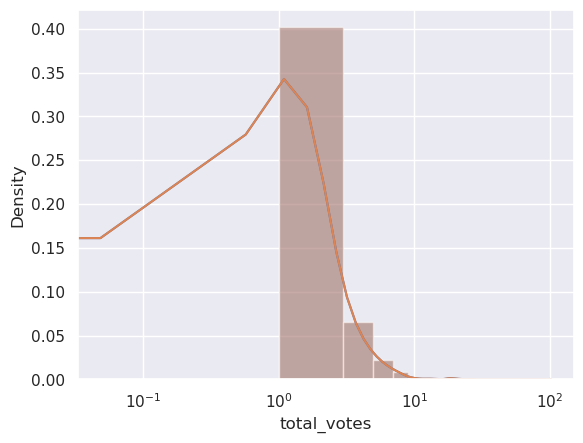

In [55]:
sns.distplot(results['total_votes'])
plt.xscale("log")
plt.show()

In [41]:
tmp[(tmp['proposal_id'] == proposal_id) & (tmp['vote'] == 'Yes')]

,proposal_id,vote,dao_id,address,vote_type_id,shares,loot,sharesRequested,lootRequested,tributeOffered,yesVotes,noVotes,yesShares,noShares
5212,7248,Yes,1,1,1,1,1,1,1,1,1,1,1,1


In [399]:
tmp = votes.merge(proposals, left_on="proposal_id", right_on="id")
tmp_votes = tmp.groupby(["dao_id", "member_id"], as_index=False).count()
tmp_votes = tmp_votes.merge(members[["id", "address"]], left_on="member_id", right_on="id")[["dao_id", "id_x", "address"]]
tmp_votes = tmp_votes.rename(columns={"id_x":"votes_count"})

In [400]:
tmp_proposals = proposals[proposals['newMember'] != "t"].groupby(['dao_id',"proposer"], as_index=False).count()[['dao_id', "proposer", "id"]]
tmp_proposals = tmp_proposals.rename(columns={"id":"proposals_count", "proposer":"address"})

In [401]:
action_counts = tmp_proposals.merge(tmp_votes, left_on=["dao_id", "address"], right_on=["dao_id", "address"],how="outer")
action_counts["proposals_count"] = action_counts["proposals_count"].fillna(0)
action_counts["votes_count"] = action_counts["votes_count"].fillna(0)
action_counts["action_count"] = action_counts["proposals_count"] + action_counts["votes_count"]

# Overall network analysis

In [2]:
tqdm.pandas()

In [3]:
daos = pd.read_csv("../../DiamondDAO_SQL_DB/daohaus.dao.csv")
members = pd.read_csv("../../DiamondDAO_SQL_DB/daohaus.member.csv")
proposals = pd.read_csv("../../DiamondDAO_SQL_DB/daohaus.proposal.csv")
votes = pd.read_csv("../../DiamondDAO_SQL_DB/daohaus.proposal_votes.csv")
daohaus_data = votes.merge(proposals, left_on="proposal_id", right_on="id").merge(members, left_on="member_id", right_on="id")[["dao_id_x", "proposal_id_x", "address"]]
daohaus_data = daohaus_data.rename(columns={"dao_id_x":"dao_id", "proposal_id_x":"proposal_id"})
daohaus_data["datasource"] = "DAOHaus"

In [4]:
pathToData = "../../shoot-your-snapshot/SnapshotScrapper/results"
snapshot_data = []
with open(os.path.join(pathToData, "spaces.json")) as f:
    spaces = json.load(f)
    
for space in tqdm(spaces):
    spacePath = os.path.join(pathToData, "spaces", space["id"])
    if os.path.isdir(spacePath):
        proposals = os.listdir(spacePath)
        if len(proposals) > 1:
            for proposalPath in proposals:
                with open(os.path.join(spacePath, proposalPath)) as f:
                    proposal = json.load(f)
                for vote in proposal["votes_data"]:
                    snapshot_data.append({
                        "dao_id": space['id'],
                        "proposal_id": proposal["id"],
                        "address": vote["voter"]
                    })
    else:
        print("missing folder: {}".format(space["id"]))
snapshot_data = pd.DataFrame.from_dict(snapshot_data)
snapshot_data["datasource"] = "Snapshot"

  0%|          | 0/3490 [00:00<?, ?it/s]

In [5]:
data = snapshot_data.append(daohaus_data)

In [6]:
def make_network(row, G=None):
    G.add_node(row["dao_id"], node_type="Dao")
    G.add_node(row["address"], node_type="Member")
    G.add_node(row["proposal_id"], node_type="Proposal")
    G.add_edge(row["address"], row["proposal_id"])
    G.add_edge(row["dao_id"], row["proposal_id"])    

In [7]:
G = nx.Graph()
data.progress_apply(make_network, G=G, axis=1)

  0%|          | 0/1163882 [00:00<?, ?it/s]

0        None
1        None
2        None
3        None
4        None
         ... 
12034    None
12035    None
12036    None
12037    None
12038    None
Length: 1163882, dtype: object

In [8]:
daos = [n for n in G.nodes if G.nodes[n]["node_type"] == "Dao"]
proposals = [n for n in G.nodes if G.nodes[n]["node_type"] == "Proposal"]
voters = [n for n in G.nodes if G.nodes[n]["node_type"] == "Member"]

In [9]:
degs = nx.degree(G)

In [10]:
daos_deg = [degs[n] for n in G.nodes if G.nodes[n]["node_type"] == "Dao"]
proposals_deg = [degs[n]-1 for n in G.nodes if G.nodes[n]["node_type"] == "Proposal"]
voters_deg = [degs[n] for n in G.nodes if G.nodes[n]["node_type"] == "Member"]

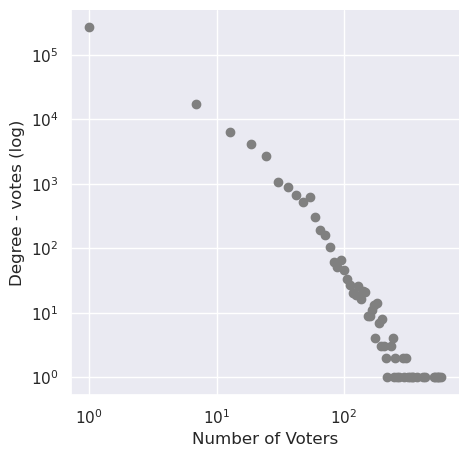

In [11]:
hist = np.histogram(voters_deg, bins=100)
fig = plt.figure(figsize=(5,5))
plt.plot(hist[1][:-1], hist[0], 'o',  color="grey")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Number of Voters")
plt.ylabel("Degree - votes (log)")
sns.despine()
plt.show()
fig.savefig("VoterDegreeDist.svg")

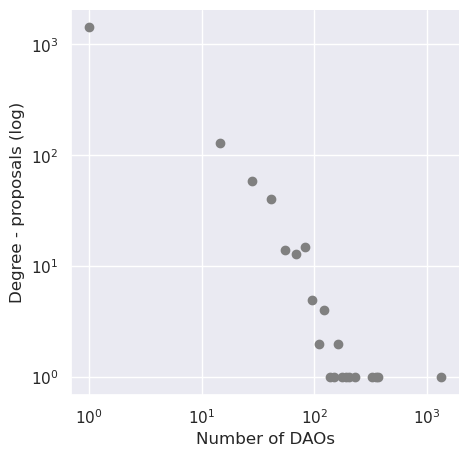

In [12]:
hist = np.histogram(daos_deg, bins=100)
fig = plt.figure(figsize=(5,5))
plt.plot(hist[1][:-1], hist[0], 'o', color="grey")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Number of DAOs")
plt.ylabel("Degree - proposals (log)")
sns.despine()
plt.show()
fig.savefig("DAOsDegreeDist.svg")

In [13]:
single_voters = [n for n in G.nodes if G.nodes[n]["node_type"] == "Member" and degs[n] > 1]

In [ ]:
subG = nx.subgraph(G, single_voters+proposals)

In [14]:
def make_network_2(row, G=None):
    G.add_node(row["dao_id"], node_type="Dao")
    G.add_node(row["address"], node_type="Member")
    G.add_edge(row["address"], row["dao_id"])

In [16]:
Gdao = nx.Graph()
data.progress_apply(make_network_2, G=Gdao, axis=1)

  0%|          | 0/1163882 [00:00<?, ?it/s]

0        None
1        None
2        None
3        None
4        None
         ... 
12034    None
12035    None
12036    None
12037    None
12038    None
Length: 1163882, dtype: object

In [19]:
daosG = nx.subgraph(Gdao, single_voters+daos)
daosG = nx.bipartite.weighted_projected_graph(Gdao, daos)

In [25]:
import community as community_louvain

In [26]:
partition = community_louvain.best_partition(daosG)

In [29]:
for node in daosG.nodes:
    daosG.nodes[node]["partition"] = partition[node]

In [30]:
nx.write_graphml(daosG, "daos_net.graphml")

In [31]:
D = nx.degree(daosG)

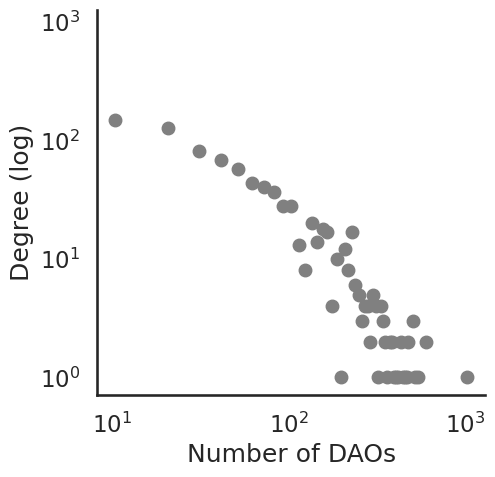

In [112]:
X = [D[n] for n in daosG]
hist = np.histogram(X, bins=100)
fig = plt.figure(figsize=(5,5))
plt.plot(hist[1][:-1], hist[0], 'o', color="grey")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Number of DAOs")
plt.ylabel("Degree (log)")
sns.despine()
plt.show()
fig.savefig("DAOsNetworkDegreeDist.svg")

In [ ]:
votersG = nx.bipartite.weighted_projected_graph(subG, single_voters)

In [ ]:
voter_net_degs = nx.degree(votersG)

In [ ]:
X = [voter_net_degs[n] for n in voter_net_degs]
hist = np.histogram(X, bins=100)
fig = plt.figure(figsize=(5,5))
plt.plot(hist[1][:-1], hist[0], 'o', color="grey")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Number of DAOs")
plt.ylabel("Degree - proposals (log)")
sns.despine()
plt.show()
fig.savefig("VoterNetworkDegreeDist.svg")

In [33]:
len(proposals)

20415

In [35]:
len(voters)

303802

In [36]:
len(daos)

1727